# CMSC 320 Final Project:
# Is Height an Advantage in Professional Tennis?
## Eric Li, Fall 2022

# Introduction

# Part 1: Data Collection

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
atp_matches_22 = pd.read_csv('/Users/ericli/Downloads/tennis_atp-master/atp_matches_2022.csv')
atp_matches_22.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2022-8888,Atp Cup,Hard,16,A,20220103,300,200000,NaN,NaN,...,50.0,32.0,7.0,10.0,3.0,5.0,11.0,3308.0,19.0,2260.0
1,2022-8888,Atp Cup,Hard,16,A,20220103,299,133430,NaN,NaN,...,33.0,21.0,8.0,9.0,3.0,6.0,14.0,2475.0,20.0,2230.0
2,2022-8888,Atp Cup,Hard,16,A,20220103,298,105138,NaN,NaN,...,80.0,62.0,20.0,16.0,6.0,7.0,19.0,2260.0,9.0,3706.0
3,2022-8888,Atp Cup,Hard,16,A,20220103,297,105807,NaN,NaN,...,27.0,17.0,1.0,7.0,4.0,8.0,20.0,2230.0,860.0,18.0
4,2022-8888,Atp Cup,Hard,16,A,20220103,296,106421,NaN,NaN,...,35.0,22.0,4.0,8.0,3.0,7.0,2.0,8640.0,11.0,3308.0


In [3]:
atp_matches_22

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2022-8888,Atp Cup,Hard,16,A,20220103,300,200000,NaN,NaN,...,50.0,32.0,7.0,10.0,3.0,5.0,11.0,3308.0,19.0,2260.0
1,2022-8888,Atp Cup,Hard,16,A,20220103,299,133430,NaN,NaN,...,33.0,21.0,8.0,9.0,3.0,6.0,14.0,2475.0,20.0,2230.0
2,2022-8888,Atp Cup,Hard,16,A,20220103,298,105138,NaN,NaN,...,80.0,62.0,20.0,16.0,6.0,7.0,19.0,2260.0,9.0,3706.0
3,2022-8888,Atp Cup,Hard,16,A,20220103,297,105807,NaN,NaN,...,27.0,17.0,1.0,7.0,4.0,8.0,20.0,2230.0,860.0,18.0
4,2022-8888,Atp Cup,Hard,16,A,20220103,296,106421,NaN,NaN,...,35.0,22.0,4.0,8.0,3.0,7.0,2.0,8640.0,11.0,3308.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2911,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Davis Cup WG2 PO: GRE vs JAM,Clay,4,D,20220304,4,209362,NaN,NaN,...,68.0,42.0,12.0,10.0,11.0,13.0,1103.0,9.0,1130.0,8.0
2912,2022-M-DC-2022-WG2-PO-GRE-JAM-01,Davis Cup WG2 PO: GRE vs JAM,Clay,4,D,20220304,5,202065,NaN,NaN,...,56.0,40.0,20.0,15.0,4.0,8.0,808.0,23.0,1390.0,4.0
2913,2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,1,138846,NaN,NaN,...,54.0,29.0,8.0,11.0,6.0,10.0,1059.0,10.0,1881.0,1.0
2914,2022-M-DC-2022-WG2-PO-HKG-BEN-01,Davis Cup WG2 PO: HKG vs BEN,Hard,4,D,20220304,2,209409,NaN,NaN,...,39.0,24.0,7.0,10.0,5.0,9.0,NaN,NaN,NaN,NaN


In [14]:
player_data = atp_matches_22.groupby(['winner_name','winner_hand','winner_ht']).size().reset_index().rename(columns={0:'wins'})
player_data.sort_values('wins', ascending=False)

,winner_name,winner_hand,winner_ht,wins
192,Stefanos Tsitsipas,R,193.0,61
69,Felix Auger Aliassime,R,193.0,60
30,Carlos Alcaraz,R,185.0,57
15,Andrey Rublev,R,188.0,51
32,Casper Ruud,R,183.0,51
...,...,...,...,...
141,Mikhail Kukushkin,R,183.0,1
138,Michael Mmoh,R,188.0,1
137,Maximilian Marterer,L,191.0,1
133,Matheus Pucinelli De Almeida,U,183.0,1


In [15]:
player_data[player_data['wins'] >= 5]

,winner_name,winner_hand,winner_ht,wins
0,Adrian Mannarino,L,183.0,28
2,Albert Ramos,L,188.0,25
3,Alejandro Davidovich Fokina,R,183.0,21
4,Alejandro Tabilo,L,188.0,17
5,Aleksandar Vukic,R,188.0,6
...,...,...,...,...
206,Ugo Humbert,L,188.0,9
207,Vasek Pospisil,R,193.0,5
210,Yannick Hanfmann,R,193.0,7
212,Yoshihito Nishioka,L,170.0,19


In [19]:
losses = []

for player in player_data['winner_name']:
    sub_df = atp_matches_22[atp_matches_22['loser_name'] == player]
    losses.append(sub_df.shape[0])

player_data['losses'] = losses
player_data

,winner_name,winner_hand,winner_ht,wins,losses
0,Adrian Mannarino,L,183.0,28,26
1,Aisam Ul Haq Qureshi,R,183.0,1,0
2,Albert Ramos,L,188.0,25,27
3,Alejandro Davidovich Fokina,R,183.0,21,26
4,Alejandro Tabilo,L,188.0,17,16
...,...,...,...,...,...
214,Yuki Bhambri,R,183.0,2,1
215,Zdenek Kolar,R,185.0,1,2
216,Zhizhen Zhang,R,193.0,5,4
217,Zizou Bergs,R,185.0,1,6


In [36]:
player_data['matches'] = player_data['wins'] + player_data['losses']
player_data['win percentage'] = 100 * player_data['wins'] / player_data['matches']
player_data = player_data[player_data['matches'] >= 10]
player_data.sort_values('win percentage', ascending=False)

/var/folders/rj/9vzg3rgd2g76cnbz39qvpsqc0000gn/T/ipykernel_95884/1697672286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['matches'] = player_data['wins'] + player_data['losses']
/var/folders/rj/9vzg3rgd2g76cnbz39qvpsqc0000gn/T/ipykernel_95884/1697672286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_data['win percentage'] = 100 * player_data['wins'] / player_data['matches']


,winner_name,winner_hand,winner_ht,wins,losses,matches,win percentage
155,Novak Djokovic,R,188.0,43,7,50,86.000000
173,Rafael Nadal,L,185.0,40,9,49,81.632653
30,Carlos Alcaraz,R,185.0,57,13,70,81.428571
148,Nick Kyrgios,R,193.0,40,12,52,76.923077
94,Jannik Sinner,R,188.0,47,17,64,73.437500
...,...,...,...,...,...,...,...
154,Norbert Gombos,R,193.0,2,9,11,18.181818
203,Tomas Martin Etcheverry,R,196.0,3,14,17,17.647059
81,Henri Laaksonen,R,185.0,3,15,18,16.666667
22,Benoit Paire,R,196.0,4,22,26,15.384615


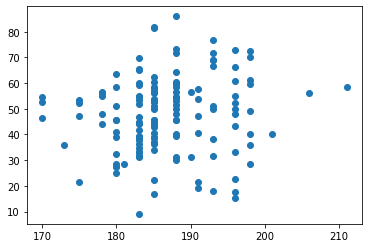

In [37]:
plt.scatter(player_data['winner_ht'], player_data['win percentage'])
plt.show()

In [38]:
player_data.groupby(['winner_hand']).mean()

,winner_ht,wins,losses,matches,win percentage
winner_hand,,,,,
L,184.571429,17.190476,16.523810,33.714286,47.067252
R,187.211864,19.872881,17.542373,37.415254,48.016024


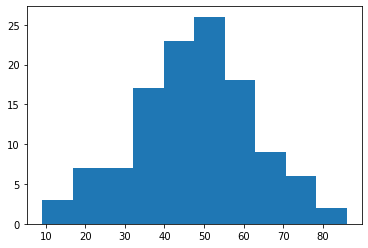

In [41]:
lefties = player_data[player_data['winner_hand'] == 'R']
plt.hist(lefties['win percentage'])
plt.show()